### linear Regression models

### Use advertising data to build a model to predict sales based on advertising through TV, Radio and Newspaper

In [1]:
import pandas                       as     pd
import numpy                        as     np
import scipy.stats                  as     stats

import seaborn                      as     sns
import matplotlib.pyplot            as     plt

import astropy.table                 as     Table
import statsmodels.api              as     sm
import statsmodels.stats.api        as     sms
from   statsmodels.compat           import lzip


from   sklearn.preprocessing        import PolynomialFeatures
from   sklearn.cross_validation     import train_test_split
from   sklearn.linear_model         import LinearRegression
from   sklearn.metrics              import mean_squared_error
from   statsmodels.compat           import lzip
from   statsmodels.stats            import diagnostic as diag


from  statsmodels.stats.outliers_influence import variance_inflation_factor


D:\Python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
Advertising_df       = pd.read_csv('../data/Advertising.csv', names = ['TV','Radio','Newspaper','Sales'], header = 0)
print(Advertising_df.shape)
print(Advertising_df.head().T)

(200, 4)
               1     2     3      4      5
TV         230.1  44.5  17.2  151.5  180.8
Radio       37.8  39.3  45.9   41.3   10.8
Newspaper   69.2  45.1  69.3   58.5   58.4
Sales       22.1  10.4   9.3   18.5   12.9


### Check for missing values

In [4]:
Advertising_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 7.8 KB


In [5]:
Advertising_df.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [6]:
Advertising_df.loc[Advertising_df['Radio'] == 0,:]

,TV,Radio,Newspaper,Sales
128,80.2,0.0,9.2,8.8


In [7]:
Advertising_df.loc[Advertising_df['Radio'] == 0] = 1.004e-20

In [8]:
Advertising_df.loc[Advertising_df['TV'] == 0,:]

,TV,Radio,Newspaper,Sales


In [9]:
Advertising_df.loc[Advertising_df['Newspaper'] == 0,:]

,TV,Radio,Newspaper,Sales


In [10]:
Advertising_df.loc[Advertising_df['Sales'] == 0,:]

,TV,Radio,Newspaper,Sales


## There are no missing values

## Split the data set into dependent and independent variables, X and y

In [11]:
X          =   Advertising_df[['TV','Radio','Newspaper']]
y          =   Advertising_df['Sales']
print(X.shape)                            
print(y.shape) 

(200, 3)
(200,)


## Build the model using statsmodel using the entire data to check assumptions

In [12]:
X_            = sm.add_constant(X) # Add an intercept to our model
model         = sm.OLS(y, X_).fit() ## OLS(output, input)
predictions   = model.predict(X_)

## Print the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     586.5
Date:                Tue, 28 May 2019   Prob (F-statistic):           1.34e-97
Time:                        07:09:54   Log-Likelihood:                -386.73
No. Observations:                 200   AIC:                             781.5
Df Residuals:                     196   BIC:                             794.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7859      0.310      8.979      0.000       2.174       3.398
TV             0.0461      0.001     33.141      0.000       0.043       0.049
Radio          0.1907      0.009     22.058      0.000       0.174       0.208
Newspaper     -0.0002      0.006     -0.036      0.971      -0.012       0.011
==============================================================================
Omnibus:                       57.861   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.829
Skew:                          -1.289   Prob(JB):                     7.14e-31
Kurtosis:                       6.165   Cond. No.                         451.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1) No outliers

Firstly we try to get the studentized residuals using get_influence( ). 

In [13]:
influence     = model.get_influence()  
resid_student = influence.resid_studentized_external

In [14]:
resid = pd.concat([X, pd.Series(resid_student,name = "Studentized Residuals")],axis = 1)
resid.head()

,TV,Radio,Newspaper,Studentized Residuals
0,NaN,NaN,NaN,0.903710
1,230.1,37.8,69.2,-1.149845
2,44.5,39.3,45.1,-1.832255
3,17.2,45.9,69.3,0.514513
4,151.5,41.3,58.5,-0.161860


If the absolute value of studentized residuals is more than 3 then that observation is considered as an outlier and hence should be removed.

In [15]:
print(X[np.absolute(resid['Studentized Residuals'] > 3)]) 

Empty DataFrame
Columns: [TV, Radio, Newspaper]
Index: []


D:\Python\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


### There are no outliers

### 2) No multi-collinearity

https://www.listendata.com/2018/01/linear-regression-in-python.html

Multi-collinearity increases the estimate of standard error of regression coefficients which makes some variables statistically insignificant when they should be significant.

We can detect multi-collinearity by:
+ By plotting scatter plots between predictor variables to have a visual description of their relationship.
+ By calculating the correlation coefficients between the variables we learn the extent of multi-collinearity in the data.
+ By calculating the Variable Inflation Factor (VIF) for each variable. 
VIF measures how much the variance of an estimated regression coefficients increases if your predictors are correlated.  The higher the value of VIF for the regressor, the more it is highly correlated to other variables.

VIF for a predictor variable is given by $\frac{1}{1 - R^2}$.
Here we take one of the explanatory variables as the target variable and all others as independent variables. So we run a regression between one of those independent variables with remaining independent variables. 

####  Detecting and Removing Multicollinearity 

##### We use the statsmodels library to calculate VIF

In [16]:
[variance_inflation_factor(X.values, j) for j in range(1, X.shape[1])]

[3.2903064706583955, 3.0549002979575346]

#### There is no multi-collinearity as their value is below 5

### 3) Constant variance

Checking heteroscedasticity Using Goldfeld Quandt we test for heteroscedasticity.
Null Hypothesis: Error terms are homoscedastic
Alternative Hypothesis: Error terms are heteroscedastic.

In [17]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)

[('F statistic', 1.350688182842476), ('p-value', 0.07130663166539326)]

The p-value is 0.0708 hence we can say that the residuals have constant variance. 

### 4) No autocorrelation

#### Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.

####  Null Hypothesis: Autocorrelation is absent.
#### Alternative Hypothesis: Autocorrelation is present.

In [18]:
diag.acorr_ljungbox(model.resid, lags = 1) 

(array([0.25021148]), array([0.61692621]))

Since p-value is 0.5042 thus we can accept the null hypothesis and can say that autocorrelation is absent.

### 5) Normality of the residuals

#### We use Jarque-Bera test  from scipy library to check the normality of residuals.

#### Null Hypothesis: The residuals are normally distributed.

####  Alternative Hypothesis: The residuals are not normally distributed.

In [19]:
jb_stat, jb_pval = stats.jarque_bera(model.resid)
print('Jarque-Bera test P value is %1.4f' % jb_pval)

Jarque-Bera test P value is 0.0000


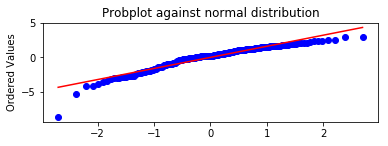

In [20]:
fig     = plt.figure()
ax1     = fig.add_subplot(211)
prob    = stats.probplot(model.resid, dist = stats.norm, plot = ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
plt.show()

D:\Python\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


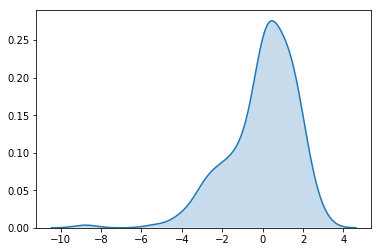

In [21]:
sns.kdeplot(model.resid, shade=True);
plt.show()

## The residuals are not normally distributed since the p-value is < 0.05

By applying various transformations to the variables, we can remove heteroscedasticity of a variable and also make it look like more normally distributed, which is a big deal for statisticians regarding normality and homoscedasticity assumptions for linear models.

https://dataunderthehood.com/2018/01/15/box-cox-transformation-with-python/

In [22]:
from astropy.table import Table
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

D:\Python\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


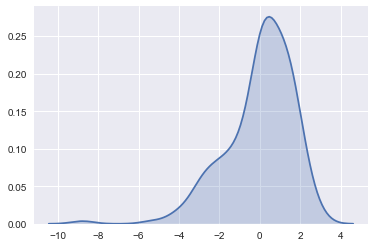

In [23]:
np.random.seed(1144) 
#x = stats.loggamma.rvs(5, size=500) + 5
x  = model.resid
sns.kdeplot(x, shade=True);
 
def normtesttab(x):
    nm_value, nm_p = stats.normaltest(x)
    jb_value, jb_p = stats.jarque_bera(x)
    data_rows = [('D’Agostino-Pearson', nm_value, nm_p),
                 ('Jarque-Bera', jb_value, jb_p)]
    t = Table(rows=data_rows, names=('Test name', 'Statistic', 'p-value'), 
              meta={'name': 'normal test table'},
          dtype=('S25', 'f8', 'f8'))
    print(t)

In [24]:
normtesttab(x)

    Test name          Statistic            p-value       
------------------ ----------------- ---------------------
D’Agostino-Pearson 57.86108530596565 2.726622205984007e-13
       Jarque-Bera 138.8290736606372                   0.0



 Various tranformations applied to the variables to make it normal 

....................................................................
Transformation  1 Square root  Jarque-Bera P Value =  6.272816448493757e-07 

Transformation  2 Log  Jarque-Bera P Value =  0.0 

Transformation  3 Inverse  Jarque-Bera P Value =  0.11247953957648638 

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                      -6.996
Model:                            OLS   Adj. R-squared:                 -6.996
Method:                 Least Squares   F-statistic:                      -inf
Date:                Tue, 28 May 2019   Prob (F-statistic):                nan
Time:                        07:09:55   Log-Likelihood:                -824.65
No. Observations:                 200   AIC:                             1651.
Df Residuals:                     199   BIC:                             1655.
Df Model:                  

D:\Python\lib\site-packages\statsmodels\regression\linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
D:\Python\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


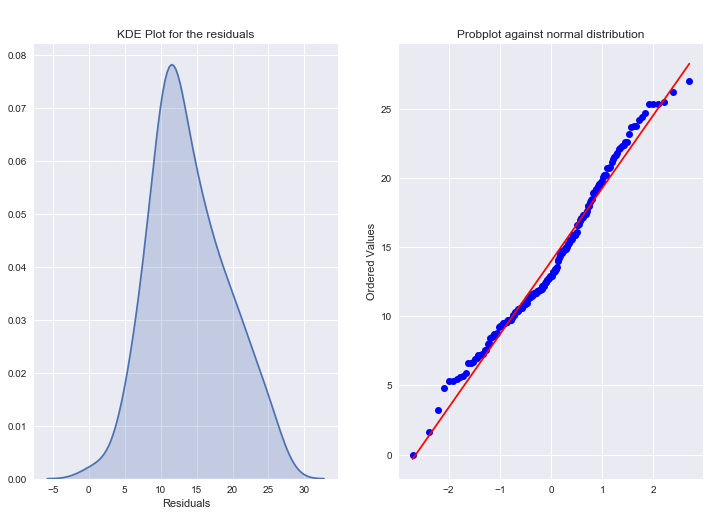

In [25]:
f_inv               = lambda x: np.sign(x) * np.power(abs(x), -1)
f_cuberoot          = lambda x: np.sign(x) * np.power(abs(x), 1./ 3)
xt_vector           = [np.sqrt(abs(X)) , np.log(X), f_inv(X), f_cuberoot(X)]

transformation_list = ['Square root', 'Log', 'Inverse' ,'Cube root']

print("\n Various tranformations applied to the variables to make it normal \n")
print('....................................................................')

ind                 = 0
for xt in xt_vector:

    X_c                = xt
    model_c            = sm.OLS(y, X_c).fit()
    jb_value, jb_p     = stats.jarque_bera(model_c.resid)
    transformation     = transformation_list[ind]
    print('Transformation ', ind + 1, transformation, ' Jarque-Bera P Value = ',jb_p, "\n")
    ind               += 1
    if jb_p > 0.05:
        print(model_c.summary())
        normtesttab(model_c.resid)
        fig     = plt.figure(figsize = (12, 8))
        ax1     = fig.add_subplot(121)
        sns.kdeplot(model_c.resid, shade=True, ax = ax1);
        ax1.set_xlabel('Residuals')
        ax1.set_title('KDE Plot for the residuals')
        ax2     = fig.add_subplot(122)
        prob    = stats.probplot(model_c.resid, dist = stats.norm, plot = ax2)
        ax2.set_xlabel('')
        ax2.set_title('\n\nProbplot against normal distribution')
        plt.show()
        Xt      = xt # return the transformed variables
        break

https://www.listendata.com/2018/01/linear-regression-in-python.html

### 6) Linearity

The residual vs fitted values plot is used to check for constant variance and linearity, and to identify potential outliers in the data.

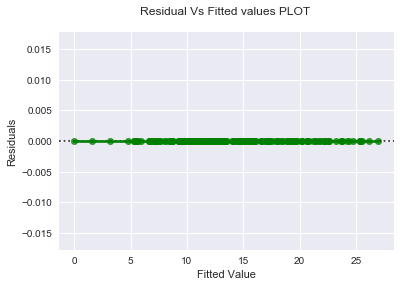

In [26]:
residuals  =  model_c.resid
# Plot the residuals after fitting a linear model
ax         = sns.residplot(y, residuals, lowess = True, color = "g")

ax.set(xlabel='Fitted Value', ylabel='Residuals', title = 'Residual Vs Fitted values PLOT \n')
plt.show()

The residual plot indicates that the model’s residuals are restricting to mean of zero to a great extent exhibiting linearity.

### Split the data into train and test datasets

* Use the train data to build a model.
* Use the test data to evaluate the model performance.
* Slit the data into 80:20 ratio to create train and test data
* Set a random seed to ensure repeatability of the results

In [27]:
x_train, x_test,  y_train, y_test = train_test_split(Xt, y, test_size = 0.2, random_state = 100)

In [28]:
df_names      = ['x_train shape', 'x_test shape', 'y_train shape', 'y_test shape']
shapes        = (x_train.shape, x_test.shape,  y_train.shape, y_test.shape)
types         = (type(x_train), type(x_test), type(y_train),type(y_test))
lzip(df_names,shapes, types)

[('x_train shape', (160, 3), pandas.core.frame.DataFrame),
 ('x_test shape', (40, 3), pandas.core.frame.DataFrame),
 ('y_train shape', (160,), pandas.core.series.Series),
 ('y_test shape', (40,), pandas.core.series.Series)]

In [29]:
X_train_            = sm.add_constant(x_train) 
X_train_.columns    = ['Constant', 'TV','Radio','Newspaper']
XT                  = np.array(X_train_)
yT                  = np.array(y_train)
#lm                  = sm.OLS(yT, XT).fit()
lm                  = sm.OLS(yT, XT).fit()

In [30]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -6.442
Model:                            OLS   Adj. R-squared:                 -6.489
Method:                 Least Squares   F-statistic:                    -136.8
Date:                Tue, 28 May 2019   Prob (F-statistic):               1.00
Time:                        07:09:55   Log-Likelihood:                -657.87
No. Observations:                 160   AIC:                             1320.
Df Residuals:                     158   BIC:                             1326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.165e-10   1.39e-10      0.836      0.4

The regression equation is given by:

Sales = 3.86577 + 0.09269 * TV + 0.03462 * Radio + 0.01597 * Newspaper -0.000466 * $TV^2$ + 0.0015105 * TV X Radio - 0.0002586 * TV X Newspaper - 9.39196 * $Radio^2$ - 0.0007483 X Radio X Newspaper + 0.0002933 * $Newspaper^2$  + 0.000000081533 * $TV^3$ - 0.0000016885 * $TV^2$ X Radio - 0.00000100052 * $TV^2$ X Newspaper - 0.0000023998 * $Radio^2$ X TV - 0.00000198309 * $TV$ * $Radio$ * $Newspaper$ - 0.000000332817 * $Newspaper^2$ * TV - 0.00000907886 * $Radio^3$ + 0.0000097386 * $Radio^2$ * Newspaper + 0.0000052069 * $Newspaper^2$ X Radio - 0.000003027 * $Newspaper^3$ 

### Model evaluation

We will evaluate our model using RMSE, MAPE and R2-score.

### Prediction Accuracy

Prediction error or residuals is the difference between the predicted target variable values and the actual target variable vaues.

Most popular measure to evaluate the model performance is Root Mean Square Error (RMSE) which is the arithmatic mean of the sum of the residuals.

The model with low RMSE is the best model among many other models.

In [31]:
# model evaluation for training set

y_train_predict       = lm.predict(X_train_)

rmse_train            = np.sqrt(mean_squared_error(y_train, y_train_predict))
mape_train            = mean_absolute_percentage_error(y_train, y_train_predict)

print("The model performance for training set")

print("--------------------------------------")

print('RMSE is {}'.format(rmse_train))

print('MAPE is {}'.format(mape_train))
print('R square is %1.3f' % lm.rsquared_adj)



The model performance for training set
--------------------------------------
RMSE is 14.772337374319498
MAPE is 6.225099601593626e+19
R square is -6.489


In [32]:
print("\n")

print("The model performance for testing set")

print("--------------------------------------")

# model evaluation for testing set
X_test_                  =   sm.add_constant(x_test) 
y_test_predict           =   lm.predict(X_test_)
rmse_test                =   (np.sqrt(mean_squared_error(y_test, y_test_predict)))
mape_test                =   mean_absolute_percentage_error(y_test, y_test_predict)

print('RMSE is {}'.format(rmse_test))
print('MAPE is {}'.format(mape_test))



The model performance for testing set
--------------------------------------
RMSE is 15.613546413922059
MAPE is 100.00002329231275
